 Todos los Import

In [1]:
import torch
from torchvision import (
    datasets,
    transforms,
    models
)
from torch.utils.data import (
    DataLoader,
    random_split
)
import kagglehub
import numpy as np
import random
from collections import Counter
import matplotlib.pyplot as plt
from torch import (
    nn,
    optim
)
import torch.nn.functional as F
from google.colab import drive
from sklearn.metrics import (
    confusion_matrix,
    classification_report
)
import seaborn as sns

Semilla

In [2]:
def seed_everything(seed):
    import random
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    np.random.seed(seed)
    random.seed(seed)

seed_everything(42)

Función para entrenar y validar la red en cada epoca

In [3]:
def train_with_validation(model, train_loader, dev_loader, criterion, optimizer, epochs=5, name="Modelo"):
    print(f"\n--- Entrenando: {name} ---")

    model.to(DEVICE)

    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_loss': [],
        'dev_acc': [],
    }

    for epoch in range(epochs):
        # --- ENTRENAMIENTO ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad() # para que no se acumulen los gradientes
            outputs = model(inputs) # obtener las predicciones del modelo


            loss = criterion(outputs, labels) # Calcular la pérdida entre las predicciones y las etiquetas reales.

            loss.backward() # calcular los gradientes de la pérdida.
            optimizer.step() #Ajustar los pesos del modelo usando los gradientes y el optimizador.

            running_loss += loss.item() # Acumular la pérdida actual para monitorear el progreso

            # Accuracy en train
            _, predicted = torch.max(outputs, 1) # Obtener la clase con la mayor probabilidad (el índice máximo).
            total += labels.size(0) # Aumentar el contador total de muestras procesadas en la época.
            correct += (predicted == labels).sum().item() # Contar cuántas predicciones coinciden con las etiquetas reales.

        avg_train_loss = running_loss / len(train_loader) # Calcular la pérdida promedio de la época dividiendo la pérdida acumulada entre el número de lotes.
        train_acc = 100.0 * correct / total # Calcular la precisión final de la época (porcentaje de aciertos).

        # --- VALIDACIÓN ---
        model.eval()
        dev_running_loss = 0.0
        dev_correct = 0
        dev_total = 0

        with torch.no_grad(): # Desactiva el cálculo de gradientes; esencial solo para evaluación. Porque ya no aprende y ya no queremos actualizar los pesos
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs) # obtener las predicciones del modelo

                # Loss validación
                loss = criterion(outputs, labels)
                dev_running_loss += loss.item()

                # Accuracy validación
                _, predicted = torch.max(outputs, 1)
                dev_total += labels.size(0)
                dev_correct += (predicted == labels).sum().item()

        avg_dev_loss = dev_running_loss / len(dev_loader)
        dev_acc = 100.0 * dev_correct / dev_total

        # Guardar histórico
        history['train_loss'].append(avg_train_loss)
        history['train_acc'].append(train_acc)
        history['dev_loss'].append(avg_dev_loss)
        history['dev_acc'].append(dev_acc)

        print(f'[Epoch {epoch + 1}/{epochs}] '
              f'Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {avg_dev_loss:.4f} | Val Acc: {dev_acc:.2f}%')

    return model, history

Función que dibuja las curvas de loss y accuracy (train y dev) guardadas en el diccionario 'history'.

In [4]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    # --- Loss ---
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['dev_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['dev_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Función que genera la matriz de confusion.

In [5]:
def plot_confusion_matrix(model, loader, class_names, device):
  model.eval()
  all_preds = []
  all_labels = []
  classes = class_names
  with torch.no_grad():
      for inputs, labels in loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs, 1)
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
  cm = confusion_matrix(all_labels, all_preds)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix')
  plt.show()

  print("\n--- Reporte de Clasificación ---")
  print(classification_report(all_labels, all_preds, target_names=classes))

Descarga Dataset

In [6]:
# Descargar dataset desde KaggleHub
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

file_path = kagglehub.dataset_download("kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none")


# Rutas del dataset

train_data_dir = f"{file_path}/logos3/train"
test_data_dir = f"{file_path}/logos3/test"


# Transformaciones de las imágenes

transform = transforms.Compose([
    transforms.Resize((64, 64)), # Deben tener todas un tamaño fijo y este es un estandar para que conserve la imagen y sea rapido de entrenar
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizar la distribucion de los valores de los pixeles con la media y desviacion estandar para que sea mas eficiente
])


# Cargar datasets

train_dataset_full = datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=transform)


# Dividir train en train/validation (80/20) con semilla fija

train_size = int(0.8 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size
train_dataset, val_dataset = random_split(train_dataset_full, [train_size, val_size])


# Crear DataLoaders

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Información general
class_names = test_dataset.classes
num_classes = len(class_names)
print(f"Tamaño del conjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del conjunto de validación: {len(val_dataset)}")
print(f"Tamaño del conjunto de prueba: {len(test_dataset)}")
print(f"Clases: {test_dataset.classes}")
print(f"Ejemplo - dimensión de una imagen: {train_dataset_full[0][0].shape}")

100%|██████████| 65.0M/65.0M [00:00<00:00, 155MB/s]

Extracting files...


Tamaño del conjunto de entrenamiento: 1390
Tamaño del conjunto de validación: 348
Tamaño del conjunto de prueba: 560
Clases: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']
Ejemplo - dimensión de una imagen: torch.Size([3, 64, 64])


Definicion arquitecturas

In [7]:
# === ARQUITECTURA BASE ===
class BaseCNN(nn.Module):
    def __init__(self, num_classes):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) # 32 filtros (detecta bordes/colores)
        self.pool = nn.MaxPool2d(2, 2) # -> 32x32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 -> 64 filtros (formas más complejas)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # Mantiene profundidad, refina características

        self.flatten_size = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_size, 512) # Capa densa: procesa características espaciales
        self.fc2 = nn.Linear(512, num_classes) # Capa salida: reduce a número de predicciones
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Bloque 1: Conv -> ReLU -> Reduce (32x32)
        x = self.pool(self.relu(self.conv2(x))) # Bloque 2: Conv -> ReLU -> Reduce (16x16)
        x = self.pool(self.relu(self.conv3(x))) # Bloque 3: Conv -> ReLU -> Reduce (8x8)
        x = x.view(-1, self.flatten_size) # Aplanar
        x = self.relu(self.fc1(x)) # Proceso de clasificación intermedia
        x = self.fc2(x) # Logits finales (sin activación, para Loss)
        return x

# === ARQUITECTURA CON DROPOUT ===
class DropoutCNN(BaseCNN):
    def __init__(self, num_classes):
        super(DropoutCNN, self).__init__(num_classes) # Hereda capas de BaseCNN
        self.dropout = nn.Dropout(0.5) # 50% de probabilidad

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x))) # Reusa conv heredadas
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, self.flatten_size)
        x = self.relu(self.fc1(x))
        x = self.dropout(x) # Dropout antes de la capa final
        x = self.fc2(x)
        return x

# === ARQUITECTURA MÁS PROFUNDA (4 Capas) ===
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.conv4 = nn.Conv2d(128, 256, 3, 1) # capa extra
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1)) # Al añadir capas, el tamaño final cambia. Para simplificar, forzamos salida 1x1 (promedio global por canal)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.relu(self.conv4(x)) # Sin pool aquí
        x = self.global_pool(x)
        x = x.view(x.size(0), -1) # Quita dimensiones espaciales extra
        x = self.fc(x)
        return x

Ejecutar Experimentos


--- Entrenando: 1. Base CNN ---
[Epoch 1/15] Train Loss: 1.2755 | Train Acc: 52.52% | Val Loss: 0.8985 | Val Acc: 67.53%
[Epoch 2/15] Train Loss: 0.8715 | Train Acc: 67.84% | Val Loss: 0.7197 | Val Acc: 75.29%
[Epoch 3/15] Train Loss: 0.6300 | Train Acc: 76.91% | Val Loss: 0.5823 | Val Acc: 81.90%
[Epoch 4/15] Train Loss: 0.4645 | Train Acc: 83.53% | Val Loss: 0.6731 | Val Acc: 81.90%
[Epoch 5/15] Train Loss: 0.4214 | Train Acc: 84.60% | Val Loss: 0.5490 | Val Acc: 85.34%
[Epoch 6/15] Train Loss: 0.3057 | Train Acc: 90.07% | Val Loss: 0.4953 | Val Acc: 86.21%
[Epoch 7/15] Train Loss: 0.1901 | Train Acc: 94.03% | Val Loss: 0.5201 | Val Acc: 85.92%
[Epoch 8/15] Train Loss: 0.1796 | Train Acc: 92.95% | Val Loss: 0.4630 | Val Acc: 89.37%
[Epoch 9/15] Train Loss: 0.0999 | Train Acc: 96.62% | Val Loss: 0.5051 | Val Acc: 85.92%
[Epoch 10/15] Train Loss: 0.0574 | Train Acc: 98.85% | Val Loss: 0.5315 | Val Acc: 89.66%
[Epoch 11/15] Train Loss: 0.0384 | Train Acc: 98.78% | Val Loss: 0.5813 | Va

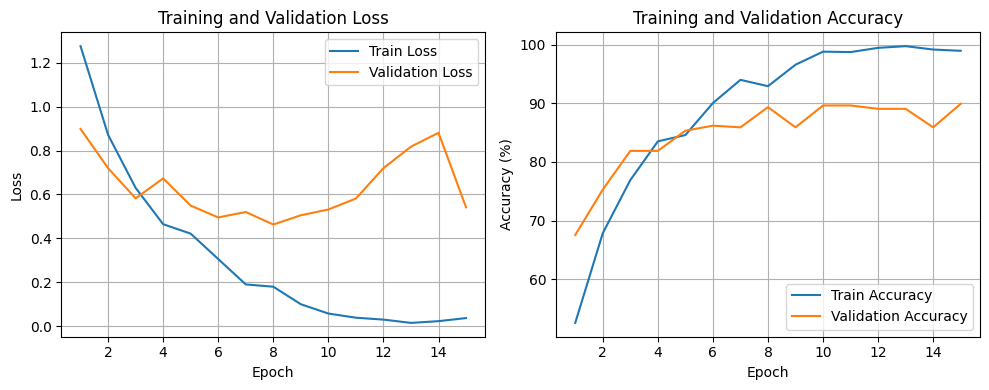

>> Matriz de Confusión (Modelo 1):


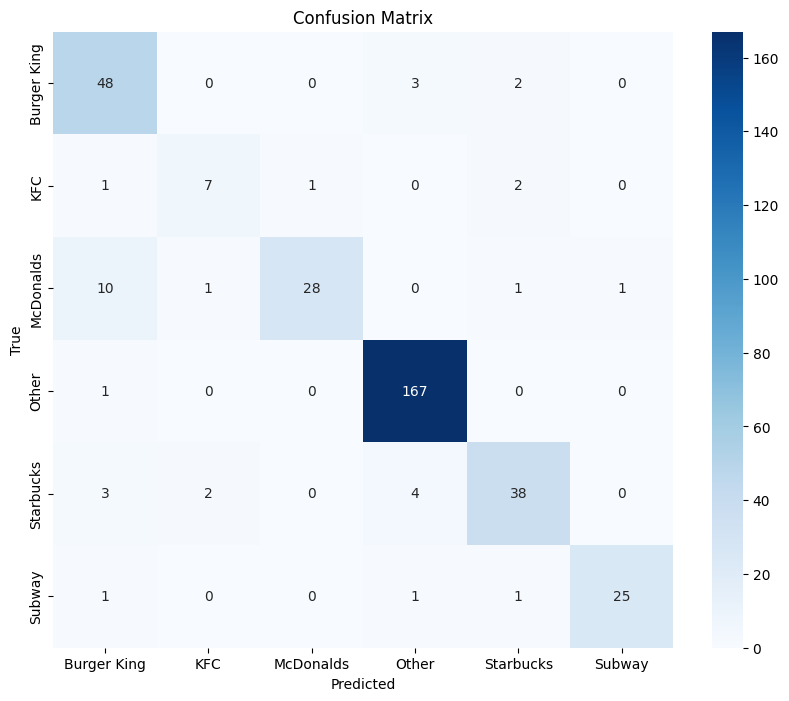


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.75      0.91      0.82        53
         KFC       0.70      0.64      0.67        11
   McDonalds       0.97      0.68      0.80        41
       Other       0.95      0.99      0.97       168
   Starbucks       0.86      0.81      0.84        47
      Subway       0.96      0.89      0.93        28

    accuracy                           0.90       348
   macro avg       0.87      0.82      0.84       348
weighted avg       0.90      0.90      0.90       348


--- Entrenando: 2. Base + SGD ---
[Epoch 1/15] Train Loss: 1.6636 | Train Acc: 40.65% | Val Loss: 1.5020 | Val Acc: 48.28%
[Epoch 2/15] Train Loss: 1.4650 | Train Acc: 47.27% | Val Loss: 1.3827 | Val Acc: 48.28%
[Epoch 3/15] Train Loss: 1.2225 | Train Acc: 53.17% | Val Loss: 1.0507 | Val Acc: 59.48%
[Epoch 4/15] Train Loss: 0.9464 | Train Acc: 64.32% | Val Loss: 0.7816 | Val Acc: 68.39%
[Epoch 5/15] Train Loss: 0.7901 

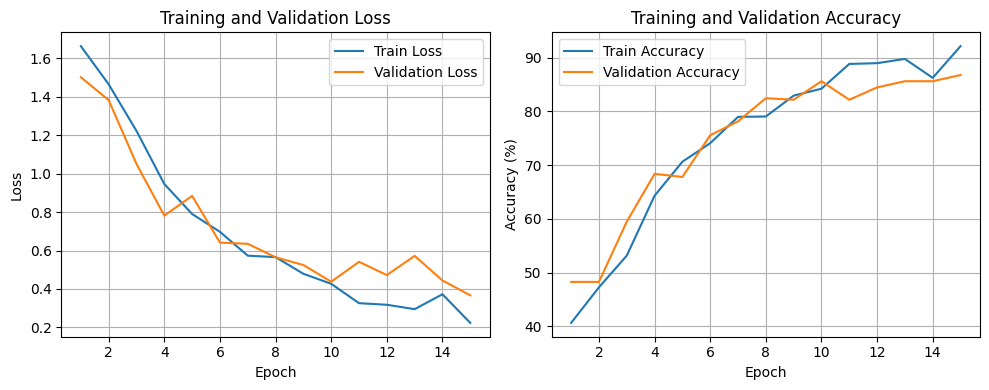

>> Matriz de Confusión (Modelo 2):


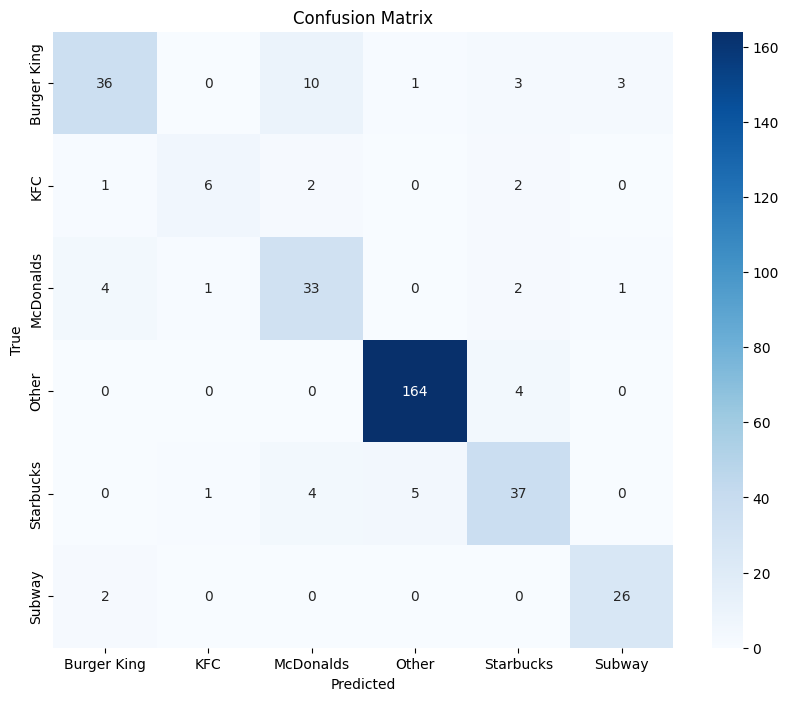


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.84      0.68      0.75        53
         KFC       0.75      0.55      0.63        11
   McDonalds       0.67      0.80      0.73        41
       Other       0.96      0.98      0.97       168
   Starbucks       0.77      0.79      0.78        47
      Subway       0.87      0.93      0.90        28

    accuracy                           0.87       348
   macro avg       0.81      0.79      0.79       348
weighted avg       0.87      0.87      0.87       348


--- Entrenando: 3. Dropout CNN ---
[Epoch 1/15] Train Loss: 1.2777 | Train Acc: 52.81% | Val Loss: 0.9396 | Val Acc: 66.67%
[Epoch 2/15] Train Loss: 0.8528 | Train Acc: 68.49% | Val Loss: 0.6921 | Val Acc: 75.86%
[Epoch 3/15] Train Loss: 0.6753 | Train Acc: 75.04% | Val Loss: 0.5919 | Val Acc: 82.18%
[Epoch 4/15] Train Loss: 0.5206 | Train Acc: 81.15% | Val Loss: 0.5124 | Val Acc: 84.48%
[Epoch 5/15] Train Loss: 0.3994

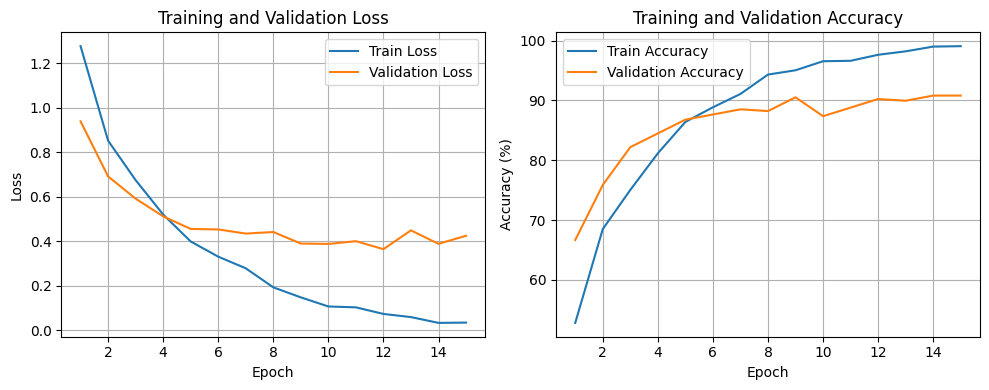

>> Matriz de Confusión (Modelo 3):


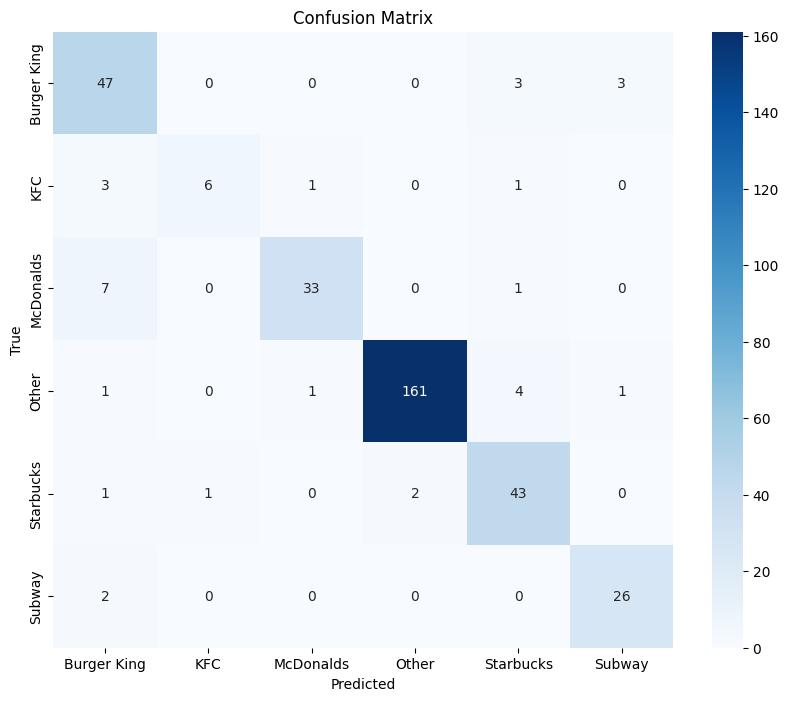


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.77      0.89      0.82        53
         KFC       0.86      0.55      0.67        11
   McDonalds       0.94      0.80      0.87        41
       Other       0.99      0.96      0.97       168
   Starbucks       0.83      0.91      0.87        47
      Subway       0.87      0.93      0.90        28

    accuracy                           0.91       348
   macro avg       0.88      0.84      0.85       348
weighted avg       0.91      0.91      0.91       348


--- Entrenando: 4. Deep CNN ---
[Epoch 1/25] Train Loss: 1.4884 | Train Acc: 45.04% | Val Loss: 1.2683 | Val Acc: 50.00%
[Epoch 2/25] Train Loss: 1.1166 | Train Acc: 56.47% | Val Loss: 0.8643 | Val Acc: 66.67%
[Epoch 3/25] Train Loss: 0.8199 | Train Acc: 70.22% | Val Loss: 0.6933 | Val Acc: 76.72%
[Epoch 4/25] Train Loss: 0.7078 | Train Acc: 74.46% | Val Loss: 0.6684 | Val Acc: 75.57%
[Epoch 5/25] Train Loss: 0.6821 | 

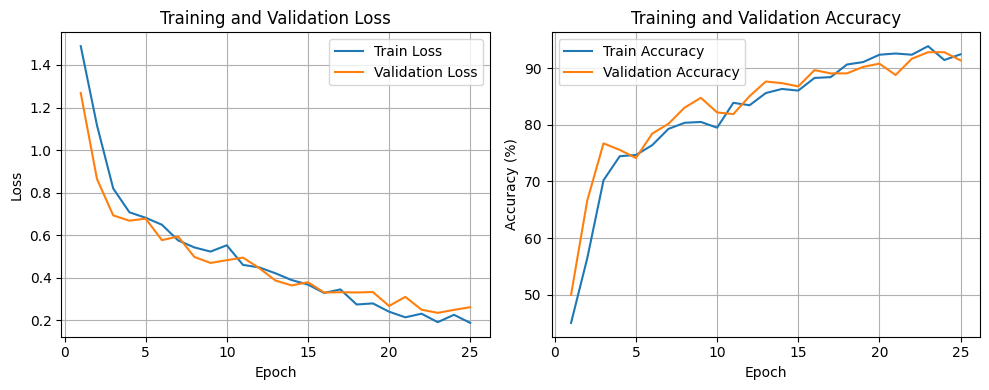

>> Matriz de Confusión (Modelo 4):


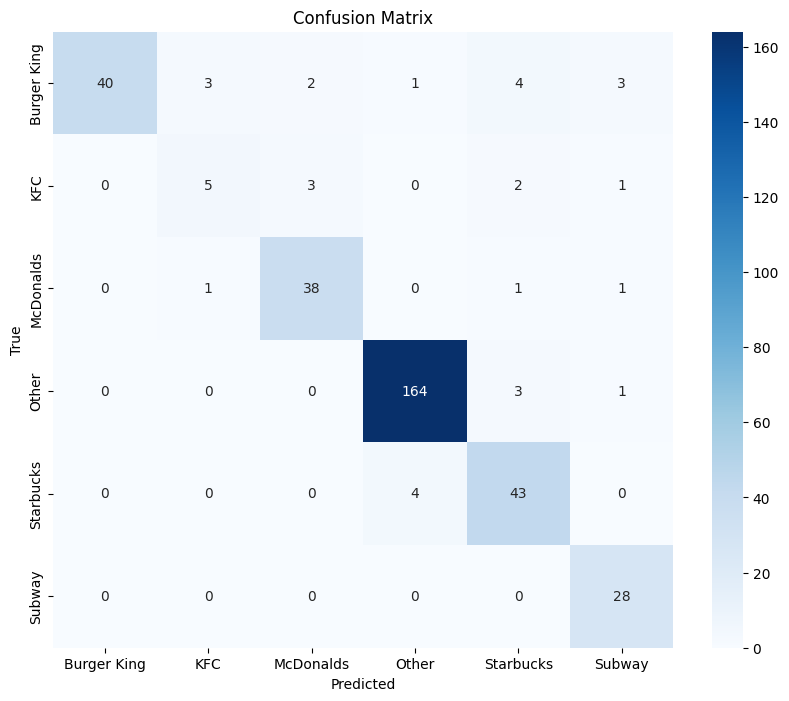


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       1.00      0.75      0.86        53
         KFC       0.56      0.45      0.50        11
   McDonalds       0.88      0.93      0.90        41
       Other       0.97      0.98      0.97       168
   Starbucks       0.81      0.91      0.86        47
      Subway       0.82      1.00      0.90        28

    accuracy                           0.91       348
   macro avg       0.84      0.84      0.83       348
weighted avg       0.92      0.91      0.91       348


--- Entrenando: 5. Data Augmentation ---
[Epoch 1/25] Train Loss: 1.3414 | Train Acc: 51.37% | Val Loss: 0.8879 | Val Acc: 65.52%
[Epoch 2/25] Train Loss: 0.9201 | Train Acc: 65.76% | Val Loss: 0.7449 | Val Acc: 72.41%
[Epoch 3/25] Train Loss: 0.7631 | Train Acc: 72.37% | Val Loss: 0.6479 | Val Acc: 76.44%
[Epoch 4/25] Train Loss: 0.6788 | Train Acc: 76.26% | Val Loss: 0.5733 | Val Acc: 80.75%
[Epoch 5/25] Train Loss: 

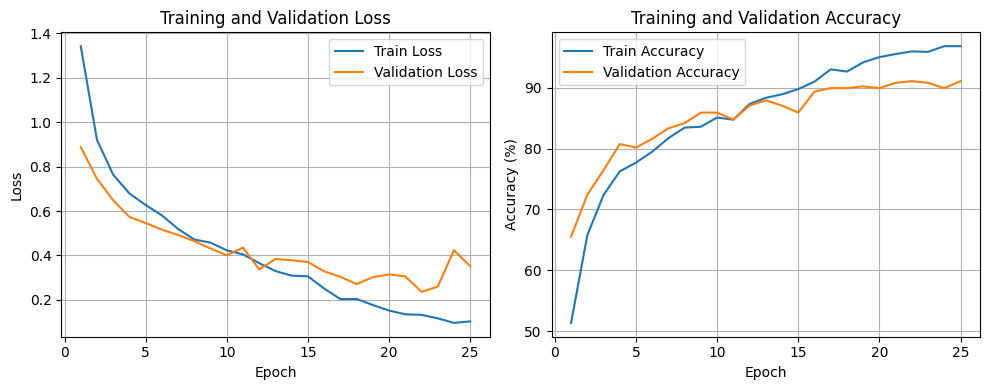

>> Matriz de Confusión (Modelo 5):


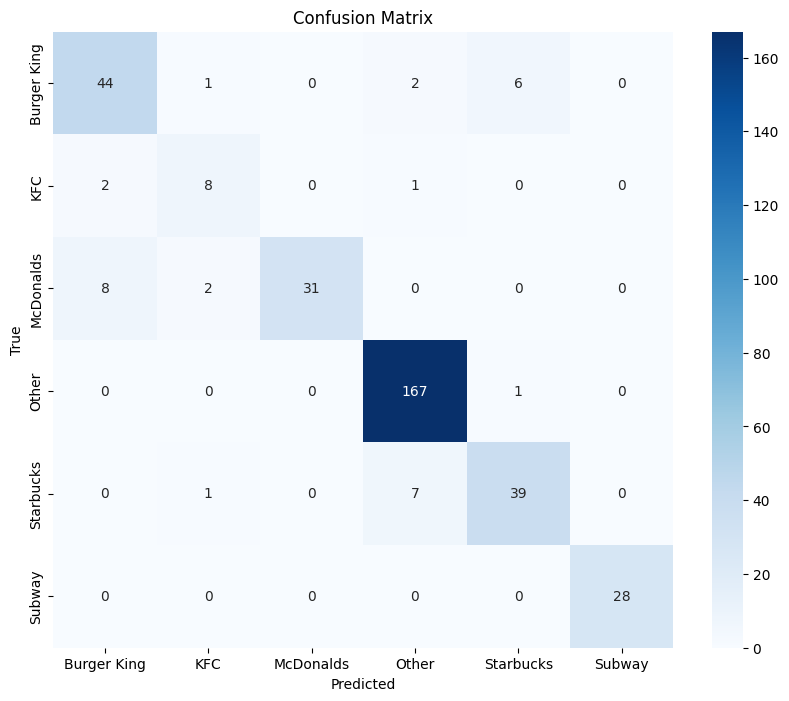


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.81      0.83      0.82        53
         KFC       0.67      0.73      0.70        11
   McDonalds       1.00      0.76      0.86        41
       Other       0.94      0.99      0.97       168
   Starbucks       0.85      0.83      0.84        47
      Subway       1.00      1.00      1.00        28

    accuracy                           0.91       348
   macro avg       0.88      0.86      0.86       348
weighted avg       0.91      0.91      0.91       348


--- COMPARATIVA DE ACCURACY (VALIDATION) ---
Base: 89.94%
SGD: 86.78%
Dropout: 90.80%
Deep: 91.38%
Augmentation: 91.09%


In [8]:
# Contenedor para resultados finales
final_results = {}

# === EXPERIMENTO 1: MODELO BASE ===

model1 = BaseCNN(num_classes).to(DEVICE) # Carga modelo básico en GPU/CPU
optimizer1 = optim.Adam(model1.parameters(), lr=0.001) # Adam: optimizador adaptativo estándar 0.001 es el estándar
criterion = nn.CrossEntropyLoss() # Función de pérdida para clasificación

# Desempaquetamos en 'model1' y 'h1' para tener el modelo y el historico
model1, h1 = train_with_validation(
    model1,
    train_loader,
    val_loader,
    criterion,
    optimizer1,
    epochs=15,
    name="1. Base CNN"
)

plot_training_history(h1)
print(">> Matriz de Confusión (Modelo 1):")
plot_confusion_matrix(model1, val_loader, class_names, DEVICE)
final_results['Base'] = h1['dev_acc'][-1]



# === EXPERIMENTO 2: LEARNING RATE BAJO (SGD) ===
model2 = BaseCNN(num_classes).to(DEVICE)
optimizer2 = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9) # SGD con Momentum

model2, h2 = train_with_validation(
    model2,
    train_loader,
    val_loader,
    criterion,
    optimizer2,
    epochs=15,
    name="2. Base + SGD"
)

plot_training_history(h2)
print(">> Matriz de Confusión (Modelo 2):")
plot_confusion_matrix(model2, val_loader, class_names, DEVICE)
final_results['SGD'] = h2['dev_acc'][-1]

# === EXPERIMENTO 3: DROPOUT ===
model3 = DropoutCNN(num_classes).to(DEVICE)
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

model3, h3 = train_with_validation(
    model3,
    train_loader,
    val_loader,
    criterion,
    optimizer3,
    epochs=15,
    name="3. Dropout CNN"
)

plot_training_history(h3)
print(">> Matriz de Confusión (Modelo 3):")
plot_confusion_matrix(model3, val_loader, class_names, DEVICE)
final_results['Dropout'] = h3['dev_acc'][-1]

# === EXPERIMENTO 4: RED PROFUNDA ===
model4 = DeepCNN(num_classes).to(DEVICE)
optimizer4 = optim.Adam(model4.parameters(), lr=0.001)

model4, h4 = train_with_validation(
    model4,
    train_loader,
    val_loader,
    criterion,
    optimizer4,
    epochs=25, # modelos profundos tardan más en converger
    name="4. Deep CNN"
)

plot_training_history(h4)
print(">> Matriz de Confusión (Modelo 4):")
plot_confusion_matrix(model4, val_loader, class_names, DEVICE)
final_results['Deep'] = h4['dev_acc'][-1]

# === EXPERIMENTO 5: DATA AUGMENTATION ===
transform_aug = transforms.Compose([
    transforms.Resize((64, 64)),          # Tamaño base
    transforms.RandomHorizontalFlip(),    # Rotación horizontal aleatoria
    transforms.RandomRotation(15),        # Rotación leve (±15 grados)
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Variación de brillo/contraste
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
aug_dataset_full = datasets.ImageFolder(root=train_data_dir, transform=transform_aug)
aug_train_subset = torch.utils.data.Subset(aug_dataset_full, train_dataset.indices)
aug_train_loader = DataLoader(aug_train_subset, batch_size=64, shuffle=True)

model5 = BaseCNN(num_classes).to(DEVICE)
optimizer5 = optim.Adam(model5.parameters(), lr=0.001)

model5, h5 = train_with_validation(
    model5,
    aug_train_loader,
    val_loader,
    criterion,
    optimizer5,
    epochs=25,
    name="5. Data Augmentation"
)

plot_training_history(h5)
print(">> Matriz de Confusión (Modelo 5):")
plot_confusion_matrix(model5, val_loader, class_names, DEVICE)
final_results['Augmentation'] = h5['dev_acc'][-1]

# === RESUMEN FINAL ===
print("\n--- COMPARATIVA DE ACCURACY (VALIDATION) ---")
for name, acc in final_results.items():
    print(f"{name}: {acc:.2f}%")

Test con el modelo que mejor resultados de.


--- EVALUACIÓN FINAL EN TEST SET ---
Accuracy Final en Test: 56.43%
Detalle por clases (Test Set):


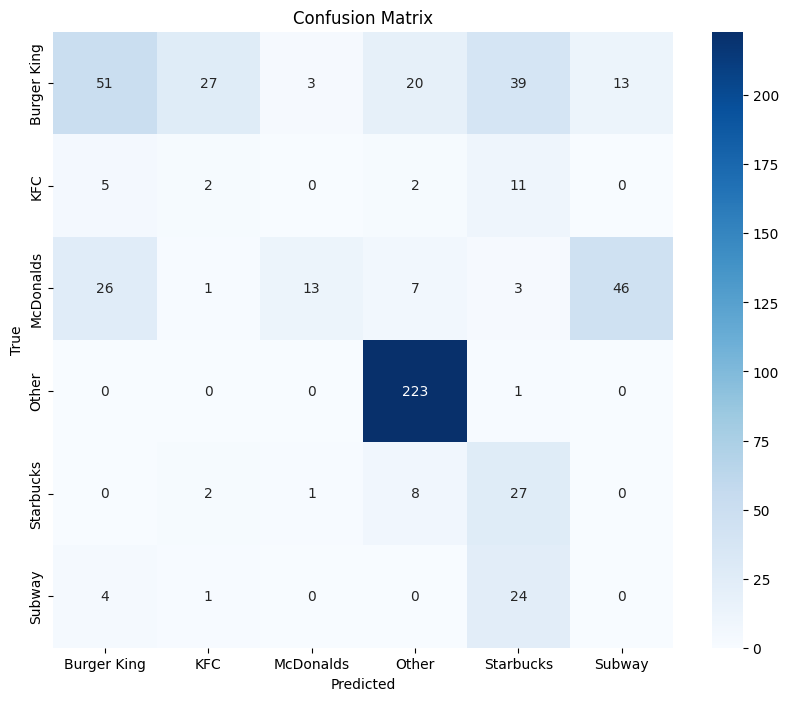


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.59      0.33      0.43       153
         KFC       0.06      0.10      0.08        20
   McDonalds       0.76      0.14      0.23        96
       Other       0.86      1.00      0.92       224
   Starbucks       0.26      0.71      0.38        38
      Subway       0.00      0.00      0.00        29

    accuracy                           0.56       560
   macro avg       0.42      0.38      0.34       560
weighted avg       0.66      0.56      0.55       560



In [9]:
print("\n--- EVALUACIÓN FINAL EN TEST SET ---")
best_model = model5

# Calcular precisión exacta en Test
correct = 0
total = 0
best_model.eval()
with torch.no_grad(): # Desactiva cálculo de gradientes (ahorra memoria/cálculo)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Accuracy Final en Test: {test_acc:.2f}%")

print("Detalle por clases (Test Set):")
plot_confusion_matrix(best_model, test_loader, class_names, DEVICE)

Transfer Learning con ResNet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 229MB/s]



--- Entrenando: 6. Transfer Learning ---
[Epoch 1/5] Train Loss: 0.8732 | Train Acc: 69.93% | Val Loss: 0.4644 | Val Acc: 80.75%
[Epoch 2/5] Train Loss: 0.3594 | Train Acc: 88.27% | Val Loss: 0.2546 | Val Acc: 93.97%
[Epoch 3/5] Train Loss: 0.2469 | Train Acc: 93.09% | Val Loss: 0.1746 | Val Acc: 95.69%
[Epoch 4/5] Train Loss: 0.1839 | Train Acc: 94.46% | Val Loss: 0.2065 | Val Acc: 92.53%
[Epoch 5/5] Train Loss: 0.1686 | Train Acc: 94.10% | Val Loss: 0.1338 | Val Acc: 97.13%


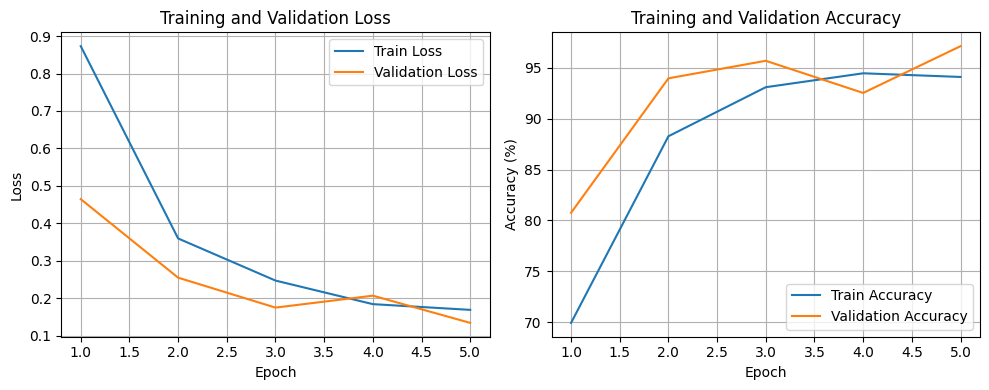


>> Matriz de Confusión (Transfer Learning):


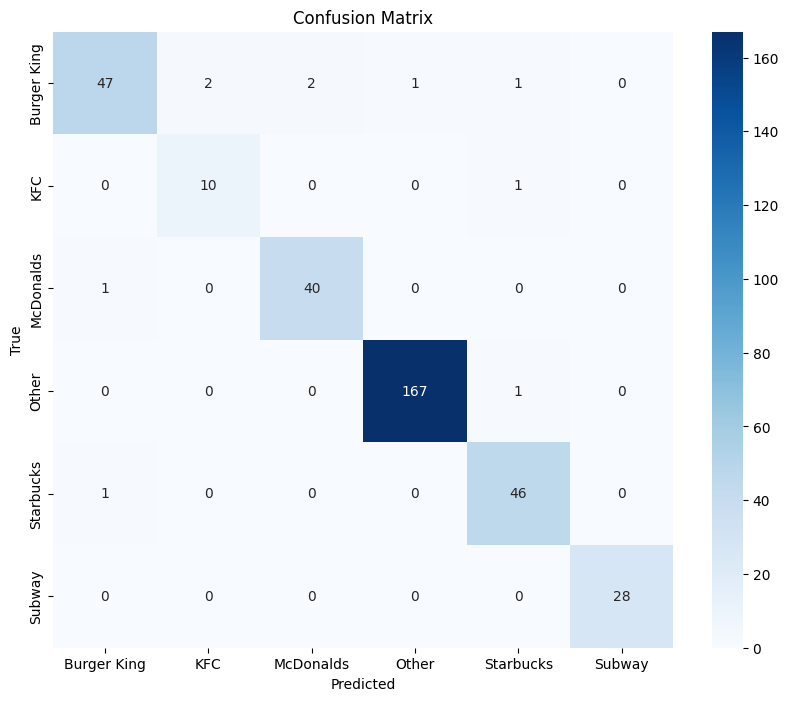


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.96      0.89      0.92        53
         KFC       0.83      0.91      0.87        11
   McDonalds       0.95      0.98      0.96        41
       Other       0.99      0.99      0.99       168
   Starbucks       0.94      0.98      0.96        47
      Subway       1.00      1.00      1.00        28

    accuracy                           0.97       348
   macro avg       0.95      0.96      0.95       348
weighted avg       0.97      0.97      0.97       348



In [10]:
transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)), # ResNet OBLIGATORIAMENTE requiere entrada de 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalización exacta usada en el pre-entrenamiento (ImageNet)
])

# Recargamos dataset solo para este experimento (por el cambio de tamaño)
tl_dataset = datasets.ImageFolder(root=train_data_dir, transform=transform_resnet)

# Usamos los mismos índices para mantener la consistencia en la división y comparar justamente
tl_train_subset = torch.utils.data.Subset(tl_dataset, train_dataset.indices)
tl_val_subset = torch.utils.data.Subset(tl_dataset, val_dataset.indices)

# Nuevos Loaders Batch menor (32) porque las imágenes son más grandes (224px)
tl_train_loader = DataLoader(tl_train_subset, batch_size=32, shuffle=True)
tl_val_loader = DataLoader(tl_val_subset, batch_size=32, shuffle=False)

# Descarga pesos aprendidos viendo 1 millón de imágenes (ImageNet)
model_tl = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Congelar capas (Feature Extractor)
for param in model_tl.parameters():
    param.requires_grad = False # Bloquea el aprendizaje en el cuerpo de la red (ahorra tiempo y memoria)

# Reemplazar la última capa que clasificaba 1000 cosas de ImageNet por la nuestra
model_tl.fc = nn.Sequential(
    nn.Linear(512, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, num_classes) # 6 clases
)

model_tl = model_tl.to(DEVICE)

# Optimizador (Solo entrenamos la capa final 'fc', es más rápido)
criterion = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(model_tl.fc.parameters(), lr=0.001)



model_tl, h_tl = train_with_validation(
    model_tl,
    tl_train_loader,
    tl_val_loader,
    criterion,
    optimizer_tl,
    epochs=5,  # Converge rapidísimo porque la red ya "sabe ver", solo aprende los nombres
    name="6. Transfer Learning"
)


plot_training_history(h_tl)

print("\n>> Matriz de Confusión (Transfer Learning):")
plot_confusion_matrix(model_tl, tl_val_loader, class_names, DEVICE)

final_results['Transfer Learning'] = h_tl['dev_acc'][-1]

Test de la red entrenada con Transfer Learning


--- EVALUACIÓN FINAL EN TEST SET ---
Accuracy Final en Test: 64.46%
Detalle por clases (Test Set):


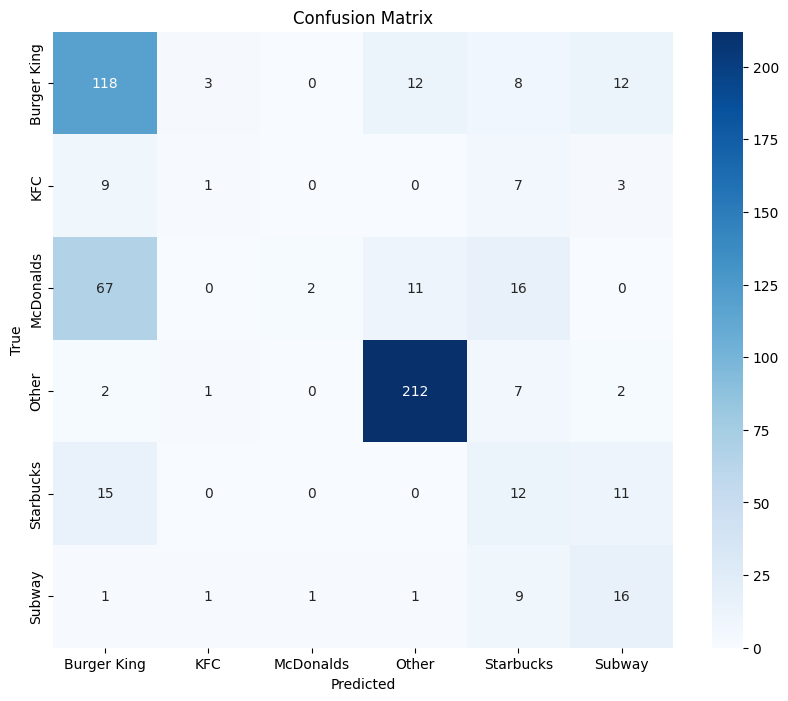


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

 Burger King       0.56      0.77      0.65       153
         KFC       0.17      0.05      0.08        20
   McDonalds       0.67      0.02      0.04        96
       Other       0.90      0.95      0.92       224
   Starbucks       0.20      0.32      0.25        38
      Subway       0.36      0.55      0.44        29

    accuracy                           0.64       560
   macro avg       0.48      0.44      0.40       560
weighted avg       0.66      0.64      0.59       560



In [11]:
print("\n--- EVALUACIÓN FINAL EN TEST SET ---")
best_model = model_tl

# 1. Calcular precisión exacta en Test
correct = 0
total = 0
best_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Accuracy Final en Test: {test_acc:.2f}%")

print("Detalle por clases (Test Set):")
plot_confusion_matrix(best_model, test_loader, class_names, DEVICE)